In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, box



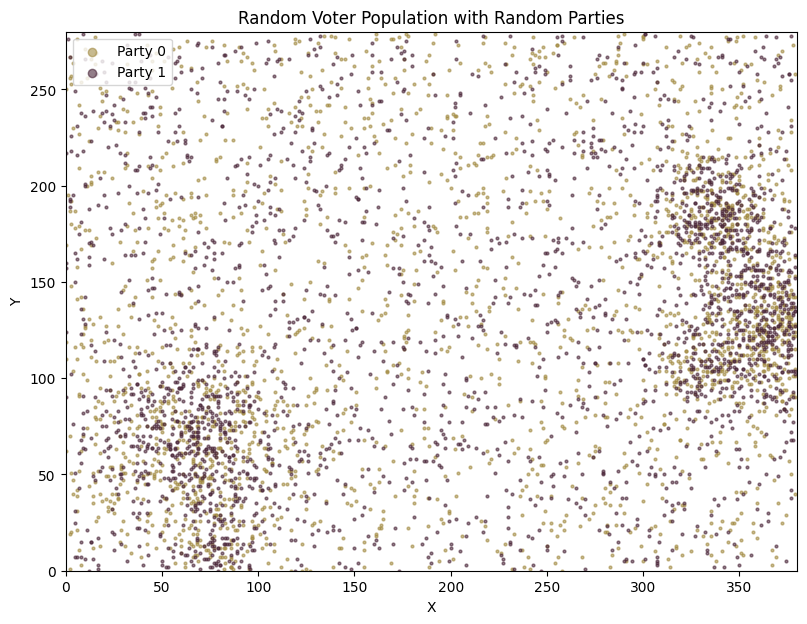

In [24]:
#THIS CODE BLOCK DISTRIBUTES VOTERS AND ASSIGNS THEMA. PARTY 

# ------------------------
# Map and population setup
# ------------------------
WIDTH = 380
HEIGHT = 280
NUM_VOTERS = 5000

NUM_PARTIES = 2  # number of different parties/colors

# Random city parameters
NUM_CITIES = 5
CITY_INTENSITY = (5, 12)
CITY_SPREAD = (10, 30)

# Base population density
density = np.full((HEIGHT, WIDTH), 1.0)
X, Y = np.meshgrid(np.arange(WIDTH), np.arange(HEIGHT))

# Generate random cities
for _ in range(NUM_CITIES):
    cx = np.random.uniform(0, WIDTH)
    cy = np.random.uniform(0, HEIGHT)
    intensity = np.random.uniform(*CITY_INTENSITY)
    sigma = np.random.uniform(*CITY_SPREAD)
    density += intensity * np.exp(-((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2))

# ------------------------
# Sample voter coordinates
# ------------------------
flat = density.flatten()
probs = flat / flat.sum()
indices = np.random.choice(len(flat), size=NUM_VOTERS, p=probs)
ys, xs = np.divmod(indices, WIDTH)
voters = np.column_stack((xs, ys))

# ------------------------
# Assign random parties/colors
# ------------------------
voter_parties = np.random.randint(0, NUM_PARTIES, size=NUM_VOTERS)
party_colors = np.random.rand(NUM_PARTIES, 3)  # random RGB colors

# ------------------------
# Plot
# ------------------------
plt.figure(figsize=(10,7))
for i in range(NUM_PARTIES):
    mask = voter_parties == i
    plt.scatter(voters[mask,0], voters[mask,1], 
                s=4, color=party_colors[i], label=f'Party {i}', alpha=0.6)

plt.title("Random Voter Population with Random Parties")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0, WIDTH)
plt.ylim(0, HEIGHT)
plt.gca().set_aspect('equal')
plt.legend(markerscale=3)
plt.show()


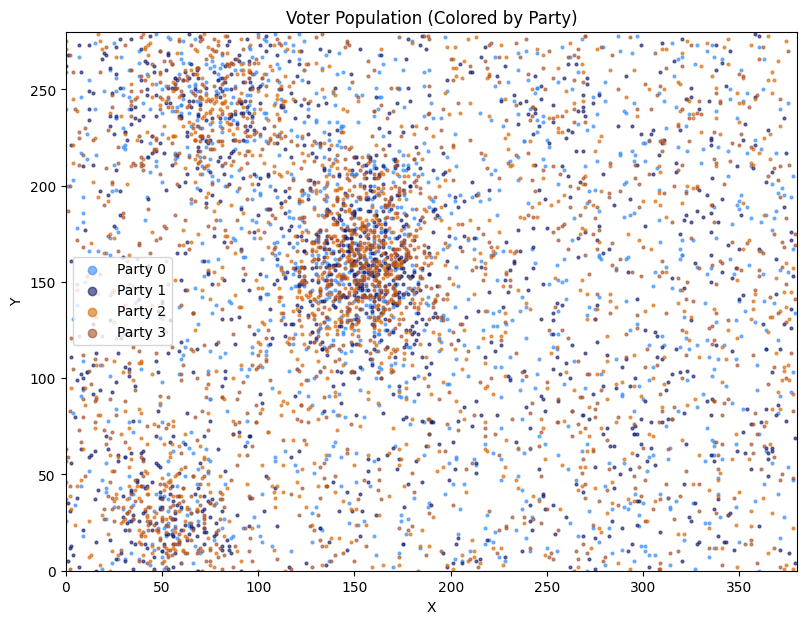

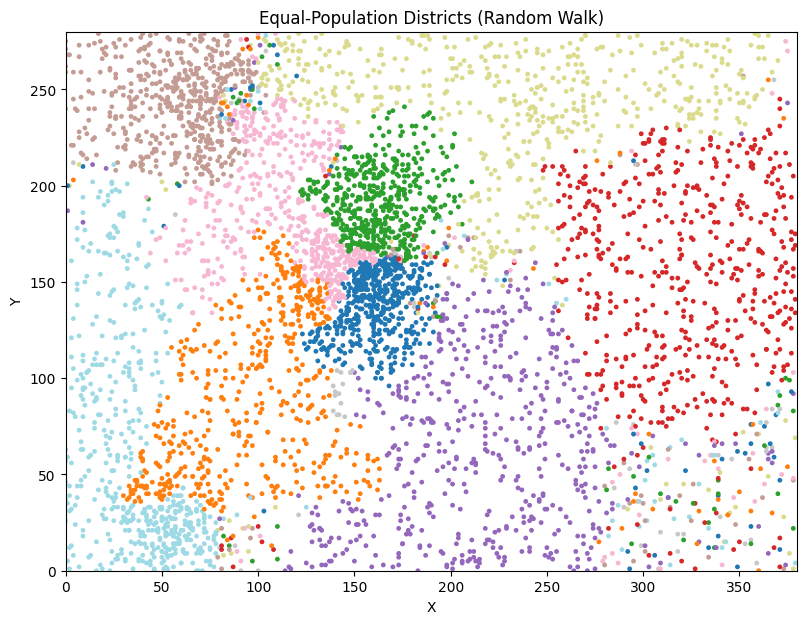

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# ------------------------
# Parameters
# ------------------------
WIDTH = 380
HEIGHT = 280
NUM_VOTERS = 5000

NUM_PARTIES = 4
NUM_DISTRICTS = 10
VOTERS_PER_DISTRICT = NUM_VOTERS // NUM_DISTRICTS

# City / density parameters
NUM_CITIES = 5
CITY_INTENSITY = (5, 12)
CITY_SPREAD = (10, 30)

np.random.seed(1)  # remove or vary for Monte Carlo runs - if you want a new map each time, remove this.

# ------------------------
# Generate population density
# ------------------------
density = np.full((HEIGHT, WIDTH), 1.0)
X, Y = np.meshgrid(np.arange(WIDTH), np.arange(HEIGHT))

for _ in range(NUM_CITIES):
    cx = np.random.uniform(0, WIDTH)
    cy = np.random.uniform(0, HEIGHT)
    intensity = np.random.uniform(*CITY_INTENSITY)
    sigma = np.random.uniform(*CITY_SPREAD)
    density += intensity * np.exp(-((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2))

# ------------------------
# Sample voters
# ------------------------
flat = density.flatten()
probs = flat / flat.sum()
indices = np.random.choice(len(flat), size=NUM_VOTERS, p=probs)
ys, xs = np.divmod(indices, WIDTH)
voters = np.column_stack((xs, ys))

# ------------------------
# Assign parties
# ------------------------
voter_parties = np.random.randint(0, NUM_PARTIES, size=NUM_VOTERS)
party_colors = np.random.rand(NUM_PARTIES, 3)

# ------------------------
# Random-walk districting
# ------------------------
def random_walk_districts(voters, num_districts, voters_per_district, k_neighbors=15):
    N = len(voters)
    district = -np.ones(N, dtype=int)

    tree = cKDTree(voters)
    unassigned = set(range(N))

    for d in range(num_districts):
        if not unassigned:
            break

        # random seed
        seed = np.random.choice(list(unassigned))
        district[seed] = d
        unassigned.remove(seed)

        frontier = [seed]

        while frontier and np.sum(district == d) < voters_per_district:
            current = frontier.pop(np.random.randint(len(frontier)))

            _, neighbors = tree.query(voters[current], k=k_neighbors)

            for n in neighbors:
                if n in unassigned:
                    district[n] = d
                    unassigned.remove(n)
                    frontier.append(n)

                    if np.sum(district == d) >= voters_per_district:
                        break

    # assign leftovers (rare, but possible)
    leftovers = list(unassigned)
    for i, v in enumerate(leftovers):
        district[v] = i % num_districts

    return district

district_labels = random_walk_districts(
    voters,
    NUM_DISTRICTS,
    VOTERS_PER_DISTRICT
)

# ------------------------
# Plot voters by party
# ------------------------
plt.figure(figsize=(10,7))
for i in range(NUM_PARTIES):
    mask = voter_parties == i
    plt.scatter(
        voters[mask,0],
        voters[mask,1],
        s=4,
        color=party_colors[i],
        label=f"Party {i}",
        alpha=0.6
    )

plt.title("Voter Population (Colored by Party)")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0, WIDTH)
plt.ylim(0, HEIGHT)
plt.gca().set_aspect("equal")
plt.legend(markerscale=3)
plt.show()

# ------------------------
# Plot districts
# ------------------------
plt.figure(figsize=(10,7))
plt.scatter(
    voters[:,0],
    voters[:,1],
    c=district_labels,
    cmap="tab20",
    s=6
)

plt.title("Equal-Population Districts (Random Walk)")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0, WIDTH)
plt.ylim(0, HEIGHT)
plt.gca().set_aspect("equal")
plt.show()



District × Party Vote Counts

District 0:
  Total voters: 125
    Party 0: 71
    Party 1: 54
------------------------------
District 1:
  Total voters: 125
    Party 0: 62
    Party 1: 63
------------------------------
District 2:
  Total voters: 125
    Party 0: 64
    Party 1: 61
------------------------------
District 3:
  Total voters: 125
    Party 0: 70
    Party 1: 55
------------------------------
District 4:
  Total voters: 125
    Party 0: 67
    Party 1: 58
------------------------------
District 5:
  Total voters: 125
    Party 0: 63
    Party 1: 62
------------------------------
District 6:
  Total voters: 125
    Party 0: 62
    Party 1: 63
------------------------------
District 7:
  Total voters: 125
    Party 0: 62
    Party 1: 63
------------------------------
District populations: {np.int64(0): np.int64(125), np.int64(1): np.int64(125), np.int64(2): np.int64(125), np.int64(3): np.int64(125), np.int64(4): np.int64(125), np.int64(5): np.int64(125), np.int64(6): np.in

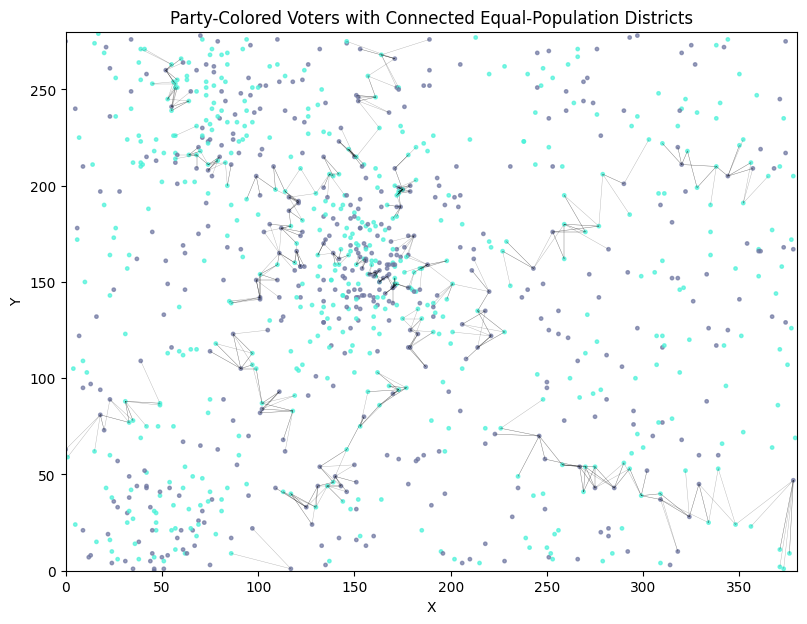

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree, ConvexHull

# ------------------------
# Parameters
# ------------------------
WIDTH = 380
HEIGHT = 280
NUM_VOTERS = 1000

NUM_PARTIES = 2
NUM_DISTRICTS = 8
VOTERS_PER_DISTRICT = NUM_VOTERS // NUM_DISTRICTS

NUM_CITIES = 5
CITY_INTENSITY = (5, 12)
CITY_SPREAD = (10, 30)

np.random.seed(1)

# ------------------------
# Generate population density
# ------------------------
density = np.full((HEIGHT, WIDTH), 1.0)
X, Y = np.meshgrid(np.arange(WIDTH), np.arange(HEIGHT))

for _ in range(NUM_CITIES):
    cx = np.random.uniform(0, WIDTH)
    cy = np.random.uniform(0, HEIGHT)
    intensity = np.random.uniform(*CITY_INTENSITY)
    sigma = np.random.uniform(*CITY_SPREAD)
    density += intensity * np.exp(
        -((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2)
    )

# ------------------------
# Sample voters
# ------------------------
flat = density.flatten()
probs = flat / flat.sum()

indices = np.random.choice(len(flat), size=NUM_VOTERS, p=probs)
ys, xs = np.divmod(indices, WIDTH)
voters = np.column_stack((xs, ys))

# ------------------------
# Assign parties
# ------------------------
voter_parties = np.random.randint(0, NUM_PARTIES, size=NUM_VOTERS)
party_colors = np.random.rand(NUM_PARTIES, 3)
voter_colors = party_colors[voter_parties]

# ------------------------
# Connected district generation (BFS region growing)
# ------------------------
def connected_districts(voters, num_districts, voters_per_district, k_neighbors=20):

    N = len(voters)
    district = -np.ones(N, dtype=int)

    tree = cKDTree(voters)
    unassigned = set(range(N))

    for d in range(num_districts):

        if not unassigned:
            break

        # Start with a random seed
        seed = np.random.choice(list(unassigned))
        district[seed] = d
        unassigned.remove(seed)

        queue = [seed]
        count = 1

        # Grow district outward
        while queue and count < voters_per_district:

            current = queue.pop(0)

            _, neighbors = tree.query(voters[current], k=k_neighbors)

            for n in neighbors:
                if n in unassigned:
                    district[n] = d
                    unassigned.remove(n)
                    queue.append(n)
                    count += 1

                    if count >= voters_per_district:
                        break

        # Safety check: if district failed to grow enough, restart it
        if count < voters_per_district:
            for i in range(N):
                if district[i] == d:
                    district[i] = -1
                    unassigned.add(i)
            return connected_districts(voters, num_districts, voters_per_district)

    return district


district_labels = connected_districts(
    voters,
    NUM_DISTRICTS,
    VOTERS_PER_DISTRICT
)
print("\nDistrict × Party Vote Counts\n")

for d in range(NUM_DISTRICTS):
    mask = district_labels == d
    total = np.sum(mask)

    party_counts = np.bincount(
        voter_parties[mask],
        minlength=NUM_PARTIES
    )

    print(f"District {d}:")
    print(f"  Total voters: {total}")
    
    for p in range(NUM_PARTIES):
        print(f"    Party {p}: {party_counts[p]}")
    
    print("-" * 30)

# ------------------------
# Verify equal population
# ------------------------
unique, counts = np.unique(district_labels, return_counts=True)
print("District populations:", dict(zip(unique, counts)))

# ------------------------
# Plot: Party-colored voters with district boundaries
# ------------------------
plt.figure(figsize=(10,7))

# Plot voters colored by party
plt.scatter(
    voters[:,0],
    voters[:,1],
    c=voter_colors,
    s=6,
    alpha=0.7
)

# Draw district boundaries based on neighbor differences
tree = cKDTree(voters)

for i in range(len(voters)):
    distances, neighbors = tree.query(voters[i], k=8)

    for n in neighbors:
        if district_labels[i] != district_labels[n]:
            plt.plot(
                [voters[i,0], voters[n,0]],
                [voters[i,1], voters[n,1]],
                color='black',
                linewidth=0.3,
                alpha=0.3
            )

'''
# Draw district boundaries using convex hull
for d in range(NUM_DISTRICTS):
    pts = voters[district_labels == d]

    if len(pts) >= 3:
        hull = ConvexHull(pts)
        for simplex in hull.simplices:
            plt.plot(
                pts[simplex,0],
                pts[simplex,1],
                color='black',
                linewidth=1
            )
'''
plt.title("Party-Colored Voters with Connected Equal-Population Districts")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0, WIDTH)
plt.ylim(0, HEIGHT)
plt.gca().set_aspect("equal")
plt.show()


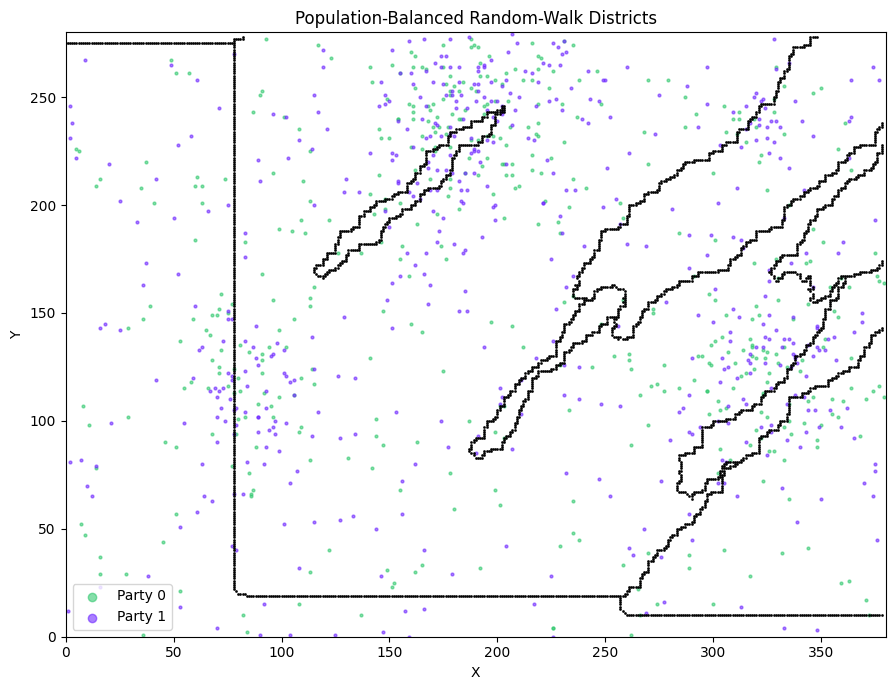

District 0: 41 voters
District 1: 0 voters
District 2: 65 voters
District 3: 7 voters
District 4: 654 voters
District 5: 54 voters
District 6: 12 voters
District 7: 23 voters


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# ------------------------
# Map and population setup
# ------------------------
WIDTH = 380
HEIGHT = 280
NUM_VOTERS = 1000

NUM_PARTIES = 2
NUM_DISTRICTS = 8

# Random city parameters
NUM_CITIES = 5
CITY_INTENSITY = (5, 12)
CITY_SPREAD = (10, 30)

# ------------------------
# Population density
# ------------------------
density = np.full((HEIGHT, WIDTH), 1.0)
X, Y = np.meshgrid(np.arange(WIDTH), np.arange(HEIGHT))

for _ in range(NUM_CITIES):
    cx = np.random.uniform(0, WIDTH)
    cy = np.random.uniform(0, HEIGHT)
    intensity = np.random.uniform(*CITY_INTENSITY)
    sigma = np.random.uniform(*CITY_SPREAD)
    density += intensity * np.exp(
        -((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2)
    )

# ------------------------
# Sample voter coordinates
# ------------------------
flat = density.flatten()
probs = flat / flat.sum()
indices = np.random.choice(len(flat), size=NUM_VOTERS, p=probs)
ys, xs = np.divmod(indices, WIDTH)
voters = np.column_stack((xs, ys))

# Voters per cell
cell_population = np.zeros((HEIGHT, WIDTH), dtype=int)
for x, y in voters:
    cell_population[y, x] += 1

# ------------------------
# Assign random parties
# ------------------------
voter_parties = np.random.randint(0, NUM_PARTIES, size=NUM_VOTERS)
party_colors = np.random.rand(NUM_PARTIES, 3)

# ------------------------
# Balanced district growth
# ------------------------
district_map = -np.ones((HEIGHT, WIDTH), dtype=int)
district_population = np.zeros(NUM_DISTRICTS, dtype=int)

target_pop = NUM_VOTERS / NUM_DISTRICTS
tolerance = target_pop * 0.05  # 5% tolerance

# Pick random seed cells
seed_xs = np.random.randint(0, WIDTH, NUM_DISTRICTS)
seed_ys = np.random.randint(0, HEIGHT, NUM_DISTRICTS)

frontiers = [deque() for _ in range(NUM_DISTRICTS)]

for i in range(NUM_DISTRICTS):
    x, y = seed_xs[i], seed_ys[i]
    district_map[y, x] = i
    district_population[i] += cell_population[y, x]
    frontiers[i].append((x, y))

neighbors = [(1,0), (-1,0), (0,1), (0,-1)]

# Grow districts
active = True
while active:
    active = False

    for i in range(NUM_DISTRICTS):
        if district_population[i] >= target_pop + tolerance:
            continue
        if not frontiers[i]:
            continue

        active = True
        x, y = frontiers[i].popleft()
        np.random.shuffle(neighbors)

        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy
            if 0 <= nx < WIDTH and 0 <= ny < HEIGHT:
                if district_map[ny, nx] == -1:
                    district_map[ny, nx] = i
                    district_population[i] += cell_population[ny, nx]
                    frontiers[i].append((nx, ny))
                    break

# ------------------------
# Fill any unassigned cells
# ------------------------
unassigned = np.argwhere(district_map == -1)

for y, x in unassigned:
    neighbor_districts = []
    for dx, dy in neighbors:
        nx, ny = x + dx, y + dy
        if 0 <= nx < WIDTH and 0 <= ny < HEIGHT:
            if district_map[ny, nx] != -1:
                neighbor_districts.append(district_map[ny, nx])

    if neighbor_districts:
        chosen = np.random.choice(neighbor_districts)
        district_map[y, x] = chosen
        district_population[chosen] += cell_population[y, x]

# ------------------------
# Plot
# ------------------------
plt.figure(figsize=(10, 7))

# Plot voters
for i in range(NUM_PARTIES):
    mask = voter_parties == i
    plt.scatter(
        voters[mask, 0],
        voters[mask, 1],
        s=4,
        color=party_colors[i],
        label=f'Party {i}',
        alpha=0.6
    )

# Draw district boundaries
boundary_x = []
boundary_y = []

for y in range(HEIGHT - 1):
    for x in range(WIDTH - 1):
        d = district_map[y, x]
        if district_map[y+1, x] != d or district_map[y, x+1] != d:
            boundary_x.append(x)
            boundary_y.append(y)

plt.scatter(boundary_x, boundary_y, s=1, c='black', alpha=0.9)

plt.title("Population-Balanced Random-Walk Districts")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0, WIDTH)
plt.ylim(0, HEIGHT)
plt.gca().set_aspect('equal')
plt.legend(markerscale=3)
plt.tight_layout()
plt.show()

# ------------------------
# Print district populations
# ------------------------
for i, pop in enumerate(district_population):
    print(f"District {i}: {pop} voters")


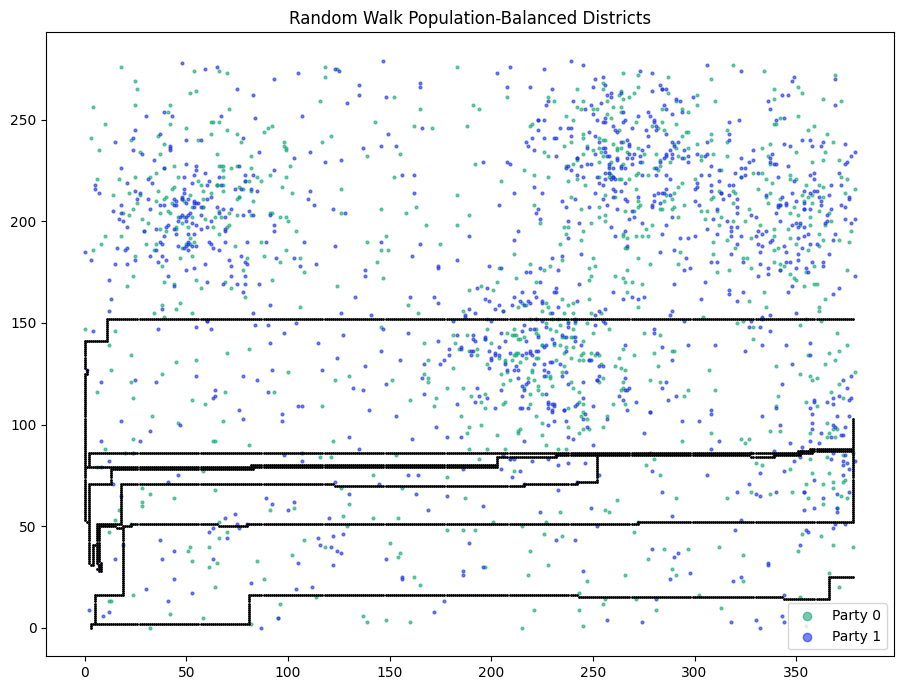

District 0: 18 voters (target 250)
District 1: 110 voters (target 250)
District 2: 32 voters (target 250)
District 3: 494 voters (target 250)
District 4: 102 voters (target 250)
District 5: 3 voters (target 250)
District 6: 1213 voters (target 250)
District 7: 28 voters (target 250)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# ------------------------
# Map and population setup
# ------------------------
WIDTH = 380
HEIGHT = 280
NUM_VOTERS = 2000

NUM_PARTIES = 2
NUM_DISTRICTS = 8

NUM_CITIES = 5
CITY_INTENSITY = (5, 12)
CITY_SPREAD = (10, 30)

# ------------------------
# Population density
# ------------------------
density = np.full((HEIGHT, WIDTH), 1.0)
X, Y = np.meshgrid(np.arange(WIDTH), np.arange(HEIGHT))

for _ in range(NUM_CITIES):
    cx = np.random.uniform(0, WIDTH)
    cy = np.random.uniform(0, HEIGHT)
    intensity = np.random.uniform(*CITY_INTENSITY)
    sigma = np.random.uniform(*CITY_SPREAD)
    density += intensity * np.exp(
        -((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2)
    )

# ------------------------
# Sample voters
# ------------------------
flat = density.flatten()
probs = flat / flat.sum()
indices = np.random.choice(len(flat), size=NUM_VOTERS, p=probs)
ys, xs = np.divmod(indices, WIDTH)
voters = np.column_stack((xs, ys))

cell_population = np.zeros((HEIGHT, WIDTH), dtype=int)
for x, y in voters:
    cell_population[y, x] += 1

max_cell_pop = cell_population.max()

# ------------------------
# Party assignment
# ------------------------
voter_parties = np.random.randint(0, NUM_PARTIES, size=NUM_VOTERS)
party_colors = np.random.rand(NUM_PARTIES, 3)

# ------------------------
# Target populations
# ------------------------
base = NUM_VOTERS // NUM_DISTRICTS
remainder = NUM_VOTERS % NUM_DISTRICTS
target_pops = np.full(NUM_DISTRICTS, base)
target_pops[:remainder] += 1

# ------------------------
# District growth setup
# ------------------------
district_map = -np.ones((HEIGHT, WIDTH), dtype=int)
district_population = np.zeros(NUM_DISTRICTS, dtype=int)

seed_xs = np.random.randint(0, WIDTH, NUM_DISTRICTS)
seed_ys = np.random.randint(0, HEIGHT, NUM_DISTRICTS)

frontiers = [deque() for _ in range(NUM_DISTRICTS)]

for i in range(NUM_DISTRICTS):
    x, y = seed_xs[i], seed_ys[i]
    district_map[y, x] = i
    district_population[i] += cell_population[y, x]
    frontiers[i].append((x, y))

neighbors = [(1,0), (-1,0), (0,1), (0,-1)]


# ------------------------
# Improved population-aware growth
# ------------------------
active = True
while active:
    active = False

    # Grow districts closest to being under target
    order = np.argsort(district_population - target_pops)

    for i in order:
        if not frontiers[i]:
            continue

        x, y = frontiers[i].popleft()

        candidate_cells = []
        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy
            if 0 <= nx < WIDTH and 0 <= ny < HEIGHT:
                if district_map[ny, nx] == -1:
                    pop = cell_population[ny, nx]
                    new_pop = district_population[i] + pop
                    deviation = abs(new_pop - target_pops[i])
                    candidate_cells.append((deviation, -pop, nx, ny))

        if candidate_cells:
            # Prefer minimal deviation, then larger cells
            _, _, nx, ny = min(candidate_cells)
            district_map[ny, nx] = i
            district_population[i] += cell_population[ny, nx]
            frontiers[i].append((nx, ny))
            active = True

# ------------------------
# Final fill (target-aware)
# ------------------------
unassigned = np.argwhere(district_map == -1)

for y, x in unassigned:
    candidates = []
    for dx, dy in neighbors:
        nx, ny = x + dx, y + dy
        if 0 <= nx < WIDTH and 0 <= ny < HEIGHT:
            d = district_map[ny, nx]
            if d != -1:
                new_pop = district_population[d] + cell_population[y, x]
                deviation = abs(new_pop - target_pops[d])
                candidates.append((deviation, d))

    if candidates:
        _, chosen = min(candidates)
        district_map[y, x] = chosen
        district_population[chosen] += cell_population[y, x]


# ------------------------
# Plot
# ------------------------
plt.figure(figsize=(10, 7))

for i in range(NUM_PARTIES):
    mask = voter_parties == i
    plt.scatter(
        voters[mask, 0],
        voters[mask, 1],
        s=4,
        color=party_colors[i],
        alpha=0.6,
        label=f'Party {i}'
    )

boundary_x = []
boundary_y = []
for y in range(HEIGHT - 1):
    for x in range(WIDTH - 1):
        d = district_map[y, x]
        if district_map[y + 1, x] != d or district_map[y, x + 1] != d:
            boundary_x.append(x)
            boundary_y.append(y)

plt.scatter(boundary_x, boundary_y, s=1, c='black')
plt.gca().set_aspect('equal')
plt.legend(markerscale=3)
plt.title("Random Walk Population-Balanced Districts")
plt.tight_layout()
plt.show()

# ------------------------
# Results
# ------------------------
for i, pop in enumerate(district_population):
    print(f"District {i}: {pop} voters (target {target_pops[i]})")



Election 1 Results:
 District 0: Party counts = [45 50 30]
 District 1: Party counts = [49 37 39]
 District 2: Party counts = [39 37 49]
 District 3: Party counts = [43 41 41]
 District 4: Party counts = [41 53 31]
 District 5: Party counts = [44 36 45]
 District 6: Party counts = [42 40 43]
 District 7: Party counts = [37 38 50]

Election 2 Results:
 District 0: Party counts = [39 46 40]
 District 1: Party counts = [35 42 48]
 District 2: Party counts = [33 42 50]
 District 3: Party counts = [35 45 45]
 District 4: Party counts = [55 37 33]
 District 5: Party counts = [42 41 42]
 District 6: Party counts = [39 34 52]
 District 7: Party counts = [37 42 46]

Election 3 Results:
 District 0: Party counts = [39 43 43]
 District 1: Party counts = [36 44 45]
 District 2: Party counts = [40 47 38]
 District 3: Party counts = [40 43 42]
 District 4: Party counts = [39 41 45]
 District 5: Party counts = [48 43 34]
 District 6: Party counts = [28 53 44]
 District 7: Party counts = [34 50 41]



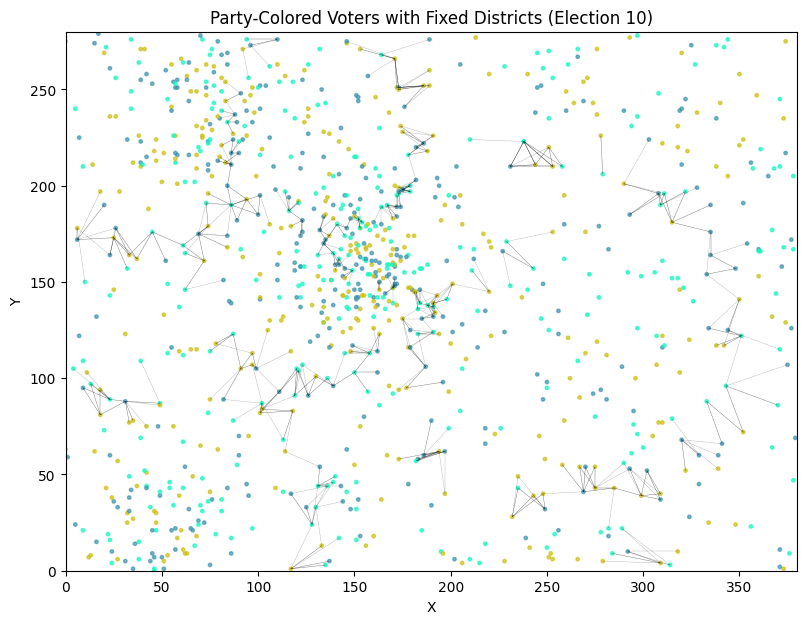

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree, ConvexHull

# ------------------------
# Parameters
# ------------------------
WIDTH = 380
HEIGHT = 280
NUM_VOTERS = 1000

NUM_PARTIES = 3
NUM_DISTRICTS = 8
VOTERS_PER_DISTRICT = NUM_VOTERS // NUM_DISTRICTS

NUM_CITIES = 5
CITY_INTENSITY = (5, 12)
CITY_SPREAD = (10, 30)

NUM_RUNS = 10  # number of elections to simulate

np.random.seed(1)

# ------------------------
# Generate population density
# ------------------------
density = np.full((HEIGHT, WIDTH), 1.0)
X, Y = np.meshgrid(np.arange(WIDTH), np.arange(HEIGHT))

for _ in range(NUM_CITIES):
    cx = np.random.uniform(0, WIDTH)
    cy = np.random.uniform(0, HEIGHT)
    intensity = np.random.uniform(*CITY_INTENSITY)
    sigma = np.random.uniform(*CITY_SPREAD)
    density += intensity * np.exp(
        -((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2)
    )

# ------------------------
# Sample voters
# ------------------------
flat = density.flatten()
probs = flat / flat.sum()

indices = np.random.choice(len(flat), size=NUM_VOTERS, p=probs)
ys, xs = np.divmod(indices, WIDTH)
voters = np.column_stack((xs, ys))

# ------------------------
# Connected district generation (BFS region growing)
# ------------------------
def connected_districts(voters, num_districts, voters_per_district, k_neighbors=20):

    N = len(voters)
    district = -np.ones(N, dtype=int)
    tree = cKDTree(voters)
    unassigned = set(range(N))

    for d in range(num_districts):
        if not unassigned:
            break

        seed = np.random.choice(list(unassigned))
        district[seed] = d
        unassigned.remove(seed)

        queue = [seed]
        count = 1

        while queue and count < voters_per_district:
            current = queue.pop(0)
            _, neighbors = tree.query(voters[current], k=k_neighbors)
            for n in neighbors:
                if n in unassigned:
                    district[n] = d
                    unassigned.remove(n)
                    queue.append(n)
                    count += 1
                    if count >= voters_per_district:
                        break

        if count < voters_per_district:
            # reset and restart if failed
            for i in range(N):
                if district[i] == d:
                    district[i] = -1
                    unassigned.add(i)
            return connected_districts(voters, num_districts, voters_per_district)

    return district

# Generate districts once
district_labels = connected_districts(voters, NUM_DISTRICTS, VOTERS_PER_DISTRICT)

# ------------------------
# Simulate multiple elections
# ------------------------
results = np.zeros((NUM_RUNS, NUM_DISTRICTS, NUM_PARTIES), dtype=int)

party_colors = np.random.rand(NUM_PARTIES, 3)

for run in range(NUM_RUNS):
    # Resample voter parties
    voter_parties = np.random.randint(0, NUM_PARTIES, size=NUM_VOTERS)
    voter_colors = party_colors[voter_parties]

    # Count votes in each district
    for d in range(NUM_DISTRICTS):
        mask = district_labels == d
        counts = np.bincount(voter_parties[mask], minlength=NUM_PARTIES)
        results[run, d, :] = counts

    print(f"\nElection {run+1} Results:")
    for d in range(NUM_DISTRICTS):
        print(f" District {d}: Party counts = {results[run,d,:]}")

# ------------------------
# Summary statistics
# ------------------------
avg_votes = results.mean(axis=0)
print("\nAverage votes per district across all runs:")
for d in range(NUM_DISTRICTS):
    print(f" District {d}: {avg_votes[d]}")

# Example: count how often Party 1 wins each district
party1_wins = (results.argmax(axis=2) == 1).sum(axis=0)
print("\nParty 1 wins per district across all runs:", party1_wins)

# ------------------------
# Plot voters with district boundaries for the first election
# ------------------------
plt.figure(figsize=(10,7))

# Use the last sampled voter_colors for visualization
plt.scatter(
    voters[:,0],
    voters[:,1],
    c=voter_colors,
    s=6,
    alpha=0.7
)

tree = cKDTree(voters)
for i in range(len(voters)):
    distances, neighbors = tree.query(voters[i], k=8)
    for n in neighbors:
        if district_labels[i] != district_labels[n]:
            plt.plot(
                [voters[i,0], voters[n,0]],
                [voters[i,1], voters[n,1]],
                color='black',
                linewidth=0.3,
                alpha=0.3
            )

plt.title(f"Party-Colored Voters with Fixed Districts (Election {NUM_RUNS})")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0, WIDTH)
plt.ylim(0, HEIGHT)
plt.gca().set_aspect("equal")
plt.show()
